In [1]:
# Importing necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
from scipy import optimize
from scipy.integrate import odeint
import matplotlib.dates as mdates
from matplotlib.ticker import FormatStrFormatter
import time
import datetime as dt
import os
import torch.autograd as autograd
from torch.autograd import Variable
from torch.utils.data import TensorDataset, DataLoader
from torch import Tensor
import torch.nn as nn
import sys
from sklearn.metrics import mean_squared_error, mean_absolute_error
sys.path.insert(0, '../../Utilities/')
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

/home/ttorku/.conda/envs/my_env1/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
#save the figures
c_dir =os.getcwd()
path = '/Output/'   #for sir models
out = c_dir +path
if not os.path.exists(out):
    os.makedirs(out)

In [3]:
dat =pd.read_csv("tndata.csv")
def data_preprocess(dat, npoints, cs ="yes"):
    tdat=dat.reindex(index=dat.index[::-1])
    Inew=tdat['TOTAL_CONFIRMED']
    Rnew =tdat['TOTAL_INACTIVE_RECOVERED']
    nn =len(Rnew)
    N =6.82*1.e6
    dd =np.arange(nn)
    if cs =="yes":
        s1 =CubicSpline(dd,Inew[:nn])
        s2 =CubicSpline(dd,Rnew[:nn])
        tt=np.linspace(0,nn, npoints)
        x, y1, y2 =tt, s1(tt), s2(tt)
        t, I1, R1 =x.reshape((-1,1)), y1.reshape((-1,1)), y2.reshape((-1,1))
        I2 =I1
        R2 =R1
        S2 =N-I2-R2
    else:
        tt=np.linspace(0,nn, npoints)
        y1 =np.array(Inew[:nn])
        y2 =np.array(Rnew[:nn])
        t, I1, R1 =tt.reshape((-1,1)), y1.reshape((-1,1)), y2.reshape((-1,1))
        I2 =I1
        R2 =R1
        S2 =N-I2-R2    
    return t[281:431,:], S2[281:431,:], I2[281:431,:], R2[281:431,:]

def noisy_data(data, sigma):
    data= data + sigma*np.std(data)*np.random.randn(data.shape[0], data.shape[1])
    return data

In [4]:
N =6.82*1.e6
npoints =100
t1, S1d, I1d, R1d =data_preprocess(dat,  npoints,  "no") #original
S2a =noisy_data(S1d,0.05)
I2a =noisy_data(I1d, 0.05)
R2a =noisy_data(R1d, 0.05)

S2b =noisy_data(S1d,0.1)
I2b =noisy_data(I1d, 0.1)
R2b =noisy_data(R1d, 0.1)

S2c =noisy_data(S1d,0.3)
I2c =noisy_data(I1d, 0.3)
R2c =noisy_data(R1d, 0.3)

S2d =noisy_data(S1d,0.6)
I2d =noisy_data(I1d, 0.6)
R2d =noisy_data(R1d, 0.6)

st ='2020-12-17'
ed ='2021-05-16'
date_begin = dt.date(2020, 12, 17) #change from 2020, 12, 17 for Case 2
date_end = date_begin + dt.timedelta(days=150) #change to 150 for case 2
delt = dt.timedelta(days=1)
dates = mpl.dates.drange(date_begin, date_end, delt)
lims = (np.datetime64(st), np.datetime64(ed))



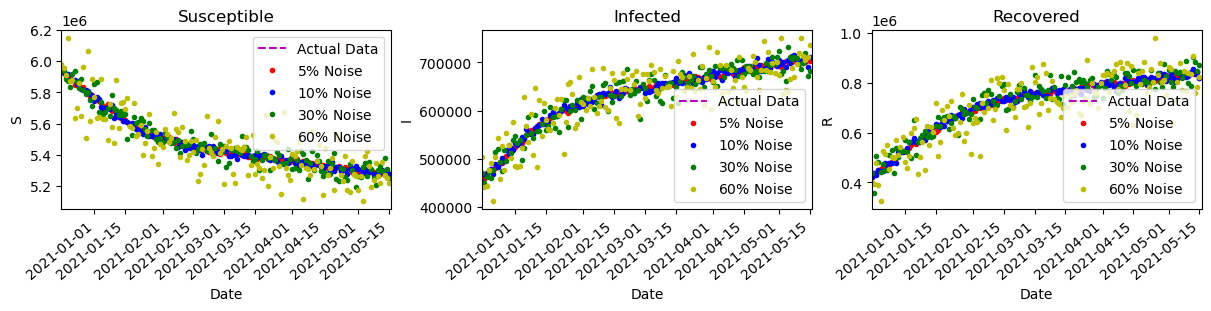

In [5]:
fig1, ax1 = plt.subplots(1, 3,constrained_layout=True,figsize=(12, 3))
ax1[0].plot(dates,S1d , '--m')
ax1[0].plot(dates,S2a, '.r')
ax1[0].plot(dates,S2b, '.b')
ax1[0].plot(dates,S2c, '.g')
ax1[0].plot(dates,S2d, '.y')
ax1[0].set_xlabel('Date')
ax1[0].set_ylabel('S')
ax1[0].set_title('Susceptible')
ax1[0].set_xlim(lims)
for label in ax1[0].get_xticklabels():
    label.set_rotation(40)
    label.set_horizontalalignment('right')
ax1[0].legend(['Actual Data',r'$5\%$ Noise', r'$10\%$ Noise', r'$30\%$ Noise', r'$60\%$ Noise'])
# ax1[0].grid(axis='y')

ax1[1].plot(dates,I1d , '--m')
ax1[1].plot(dates,I2a , '.r')
ax1[1].plot(dates,I2b , '.b')
ax1[1].plot(dates,I2c , '.g')
ax1[1].plot(dates,I2d , '.y')
ax1[1].set_xlabel('Date')
ax1[1].set_ylabel('I')
ax1[1].set_title('Infected')
ax1[1].set_xlim(lims)
for label in ax1[1].get_xticklabels():
    label.set_rotation(40)
    label.set_horizontalalignment('right')
ax1[1].legend(['Actual Data',r'$5\%$ Noise', r'$10\%$ Noise', r'$30\%$ Noise', r'$60\%$ Noise'])
# ax1[1].grid(axis='y')

ax1[2].plot(dates,R1d , '--m')
ax1[2].plot(dates,R2a , '.r')
ax1[2].plot(dates,R2b , '.b')
ax1[2].plot(dates,R2c , '.g')
ax1[2].plot(dates,R2d , '.y')
ax1[2].set_xlabel('Date')
ax1[2].set_ylabel('R')
ax1[2].set_title('Recovered')
ax1[2].set_xlim(lims)
for label in ax1[2].get_xticklabels():
    label.set_rotation(40)
    label.set_horizontalalignment('right')
ax1[2].legend(['Actual Data',r'$5\%$ Noise', r'$10\%$ Noise', r'$30\%$ Noise', r'$60\%$ Noise'])
# ax1[2].grid(axis='y')
# fig1.savefig(out+"actualdata.eps")
fig1.savefig(out+"actualdata.pdf")

### Plot Graphs

In [6]:
def plotting_graphs(S1,I1, R1, n, Sd, Id, Rd, Ss, Is, Rs, eta, v, sigma, name, S_std, I_std, R_std):
    font= 20
    nn =150
    today = '04/16/2021' # Update this to include more data 
    days = pd.date_range(start='03/12/2020',end=today) 
    dd = np.arange(len(days))
    t = np.reshape(dd, [-1])
    nd = 3000
    days1 =np.arange(0,nn,1)
    N =6.82*1.e6
    Sdata, Idata, Rdata =S1/N,I1/N, R1/N
    Td = np.linspace(0,nn,nd)
    results0 = np.zeros((n,nd))
    results0[0,:] = Td
    results1 = Sd
    results2 = Id
    results3 = Rd
    results4 = Ss
    results5 = Is
    results6 = Rs
    fig, (ax0, ax1, ax2) = plt.subplots(nrows=1, ncols=3, sharex=True, figsize=(25, 7))
    ax0.set_title('Susceptible',fontsize = 20)
    # ax0.plot(days1,S1d*N,'ok',markevery=10)
    ax0.plot(days1,Sdata,'o',markevery=10)
    ax0.plot(results0[0,:],results1,'--r')
    ax0.plot(results0[0,:],results4,'--b')
    ax0.fill_between(results0[0,:],
                     results4-(1.96*S_std/np.sqrt(results4.shape[0])),
                     results4+(1.96*S_std/np.sqrt(results4.shape[0])),alpha=0.5)
    ax0.set_xlabel('Days',fontsize = 20)
    ax0.set_ylabel('S',fontsize = 20)
    # ax0.set_ylabel('Population Percent',fontsize = 20)
    ax0.legend(('{} Noisy Data'.format(name), 'Deterministic', 'Stochastic'),loc='best',fontsize = 20)
    ax0.tick_params(labelsize=16)
    
    ax1.set_title('Infected',fontsize = 20)
    # ax0.plot(days1,I1d*N,'ok',markevery=10)
    ax1.plot(days1,Idata,'o',markevery=10)
    ax1.plot(results0[0,:],results2,'--r')
    ax1.plot(results0[0,:],results5,'--b')
    ax1.fill_between(results0[0,:],
                     results5-(1.96*I_std/np.sqrt(results5.shape[0])),
                     results5+(1.96*I_std/np.sqrt(results5.shape[0])),alpha=0.5)
    ax1.set_xlabel('Days',fontsize = 20)
    ax1.set_ylabel('I',fontsize = 20)
    ax1.legend(('{} Noisy Data'.format(name),'Determinstic', 'Stochastic'),loc='best',fontsize = 20)
    ax1.tick_params(labelsize=16)

    ax2.set_title('Recovered',fontsize = 20)
    # ax0.plot(days1,R1d*N,'ok',markevery=10)
    ax2.plot(days1,Rdata,'o',markevery=10)
    ax2.plot(results0[0,:],results3,'--r')
    ax2.plot(results0[0,:],results6,'--b')
    ax2.fill_between(results0[0,:],
                     results6-(1.96*R_std/np.sqrt(results6.shape[0])),
                     results6+(1.96*R_std/np.sqrt(results6.shape[0])),alpha=0.5)
    ax2.set_xlabel('Days',fontsize = 20)
    ax2.set_ylabel('R',fontsize = 20)
    ax2.legend(('{} Noisy Data'.format(name),'Determinstic', 'Stochastic'),loc='best',fontsize = 20)
    ax2.tick_params(labelsize=16)
    fig.savefig(out+"fig_{}_{}_{}.pdf".format(eta, v, sigma))
    fig.suptitle('When noise level $\sigma=${}'.format(name), fontsize=font)
    fig.subplots_adjust(bottom=0.1, right=1.0, top=0.85)
    plt.show()   
    return

## $\sigma =5\%$

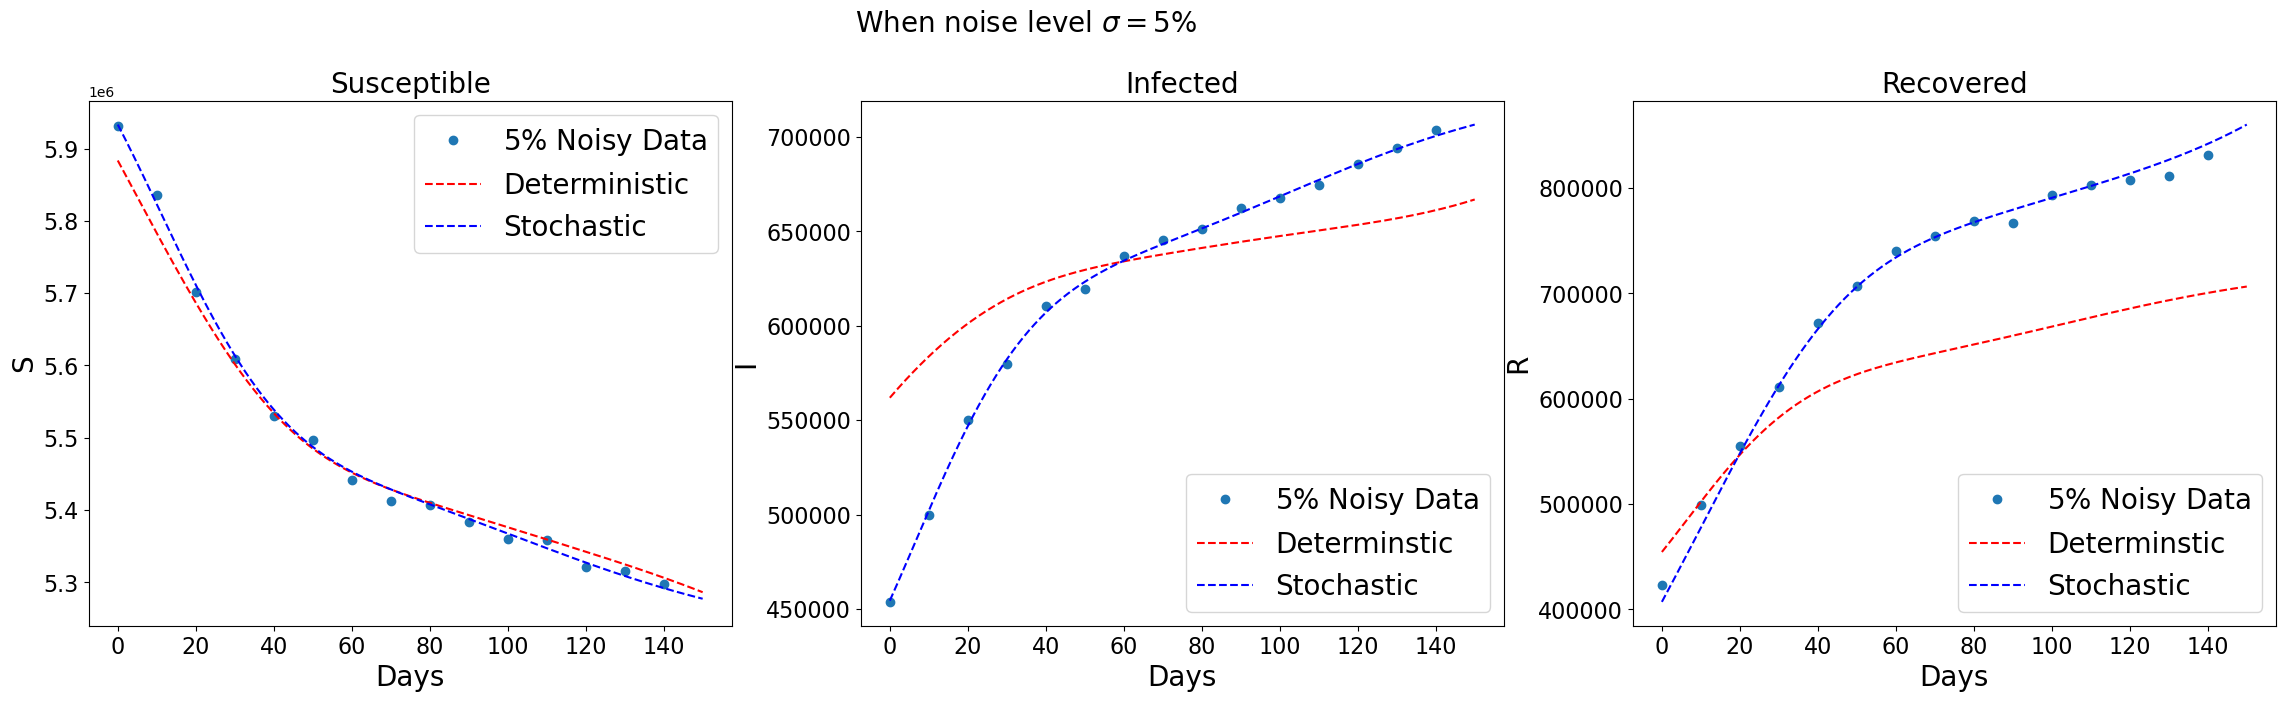

In [7]:
s10_s =np.loadtxt('Output/S_stoM_0.05_0.94_0.1.txt')*N
i10_s =np.loadtxt('Output/I_stoM_0.05_0.94_0.1.txt')*N
r10_s =np.loadtxt('Output/R_stoM_0.05_0.94_0.1.txt')*N
s10_std =np.loadtxt('Output/S_stoS_0.05_0.94_0.1.txt')*N
i10_std =np.loadtxt('Output/I_stoS_0.05_0.94_0.1.txt')*N
r10_std =np.loadtxt('Output/R_stoS_0.05_0.94_0.1.txt')*N
s10_d =np.loadtxt('Output1/S_det_0.05_0.94_0.1.txt')*N
i10_d =np.loadtxt('Output1/I_det_0.05_0.94_0.1.txt')*N
r10_d =np.loadtxt('Output1/R_det_0.05_0.94_0.1.txt')*N
n =1
Sd, Id, Rd =s10_d, i10_d, r10_s
Ss, Is, Rs =s10_s, i10_s, r10_d
S_std, I_std, R_std =s10_std, i10_std, r10_std
S1, I1, R1 =S2a, I2a, R2a
eta, v, sigma =0.94, 0.1, 0.05
name =r'$5\%$'

plotting_graphs(S1*N,I1*N, R1*N, n, Sd, Id, Rd, Ss, Is, Rs, eta, v, sigma, name, S_std, I_std, R_std)

## $\sigma=10\%$

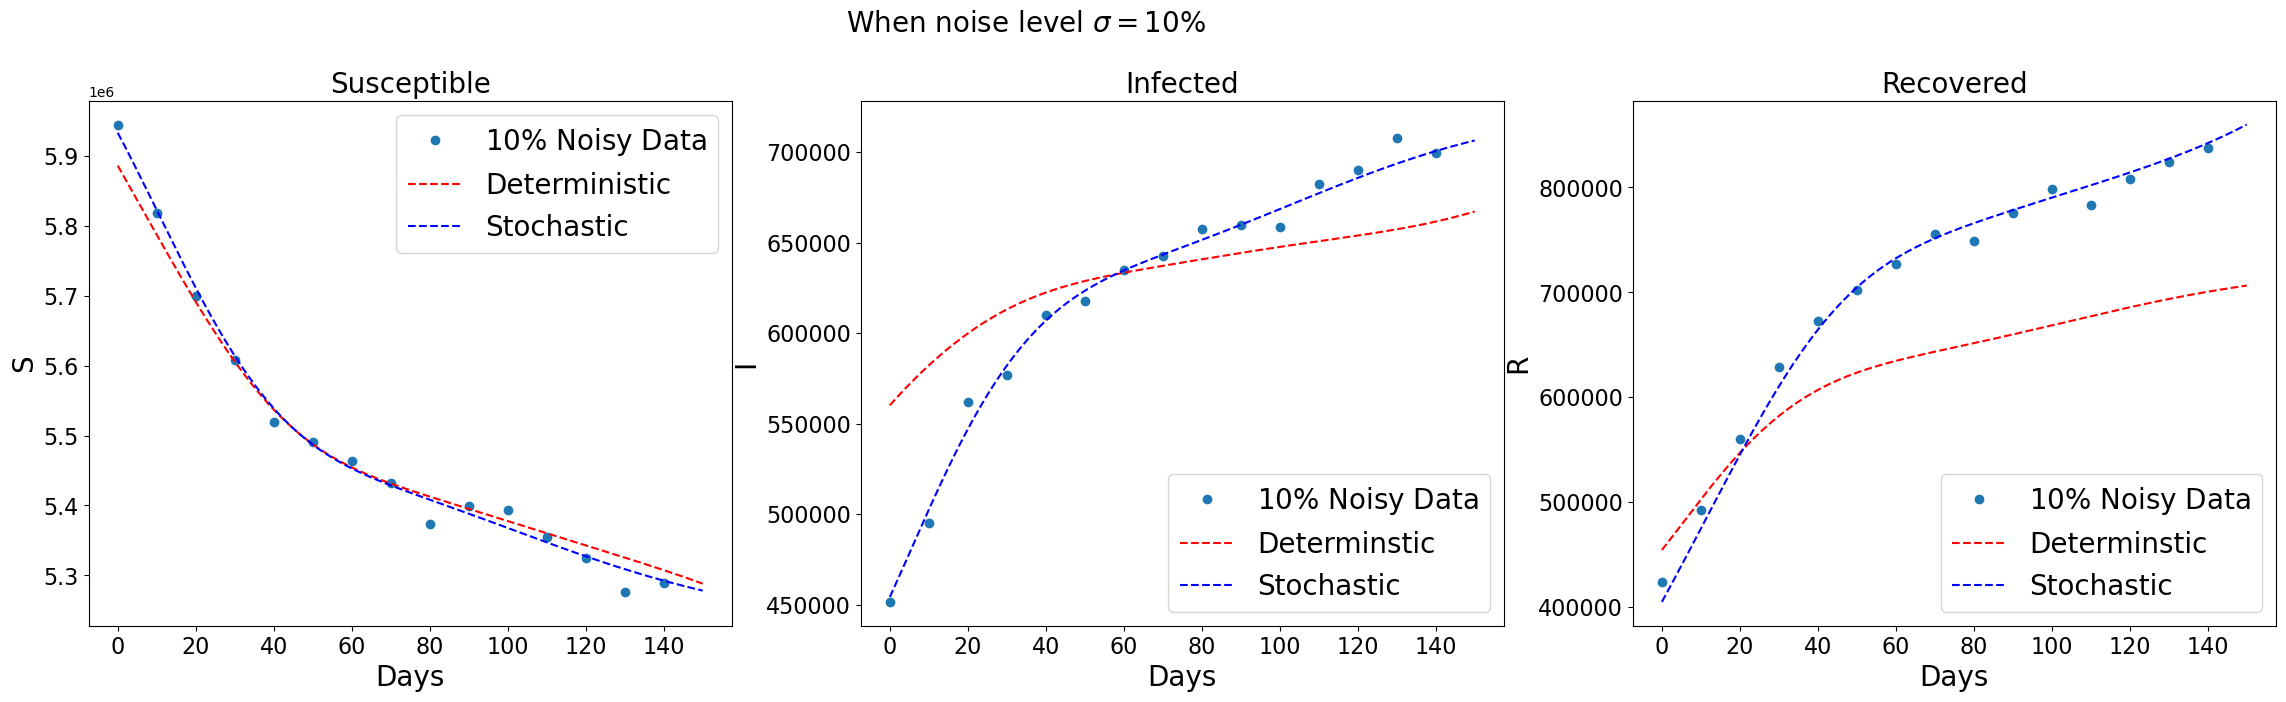

In [8]:
s10_s =np.loadtxt('Output/S_stoM_0.1_0.94_0.1.txt')*N
i10_s =np.loadtxt('Output/I_stoM_0.1_0.94_0.1.txt')*N
r10_s =np.loadtxt('Output/R_stoM_0.1_0.94_0.1.txt')*N
s10_std =np.loadtxt('Output/S_stoS_0.1_0.94_0.1.txt')*N
i10_std =np.loadtxt('Output/I_stoS_0.1_0.94_0.1.txt')*N
r10_std =np.loadtxt('Output/R_stoS_0.1_0.94_0.1.txt')*N
s10_d =np.loadtxt('Output1/S_det_0.1_0.94_0.1.txt')*N
i10_d =np.loadtxt('Output1/I_det_0.1_0.94_0.1.txt')*N
r10_d =np.loadtxt('Output1/R_det_0.1_0.94_0.1.txt')*N
n =1
Sd, Id, Rd =s10_d, i10_d, r10_s
Ss, Is, Rs =s10_s, i10_s, r10_d
S_std, I_std, R_std =s10_std, i10_std, r10_std
eta, v, sigma =0.94, 0.1, 0.1
S1, I1, R1 =S2b, I2b, R2b
name =r'$10\%$'

plotting_graphs(S1*N,I1*N, R1*N, n, Sd, Id, Rd, Ss, Is, Rs, eta, v, sigma, name, S_std, I_std, R_std)

## $\sigma =30\%$

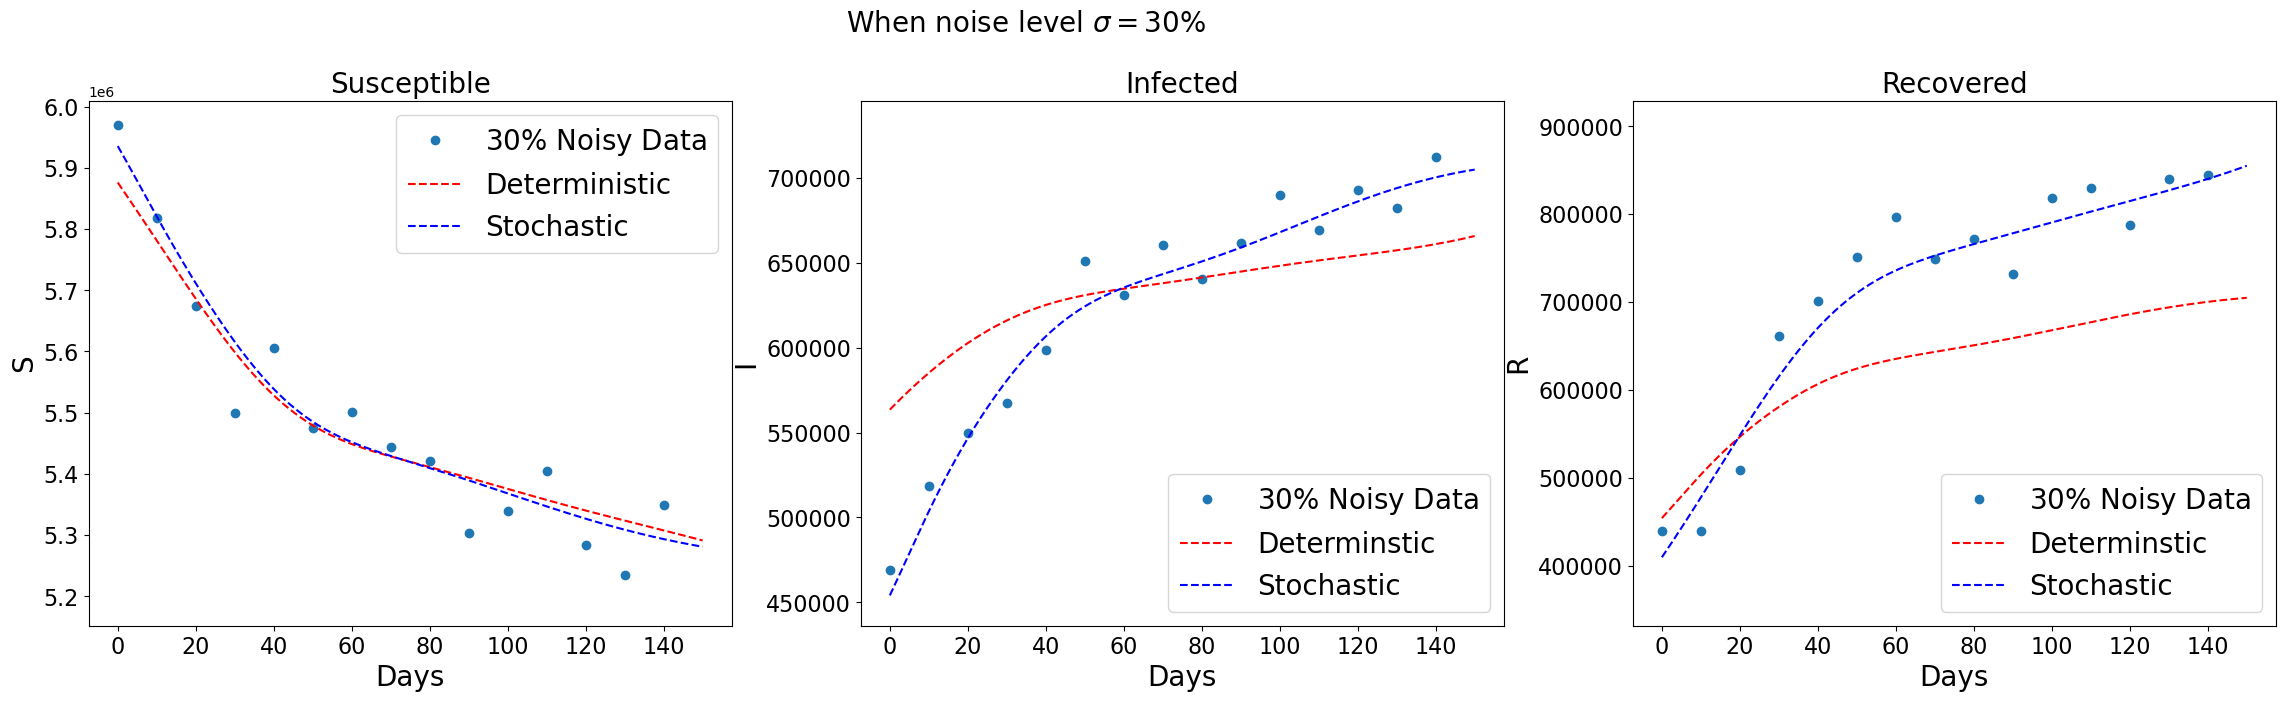

In [9]:
s10_s =np.loadtxt('Output/S_stoM_0.3_0.94_0.1.txt')*N
i10_s =np.loadtxt('Output/I_stoM_0.3_0.94_0.1.txt')*N
r10_s =np.loadtxt('Output/R_stoM_0.3_0.94_0.1.txt')*N
s10_std =np.loadtxt('Output/S_stoS_0.3_0.94_0.1.txt')*N
i10_std =np.loadtxt('Output/I_stoS_0.3_0.94_0.1.txt')*N
r10_std =np.loadtxt('Output/R_stoS_0.3_0.94_0.1.txt')*N
s10_d =np.loadtxt('Output1/S_det_0.3_0.94_0.1.txt')*N
i10_d =np.loadtxt('Output1/I_det_0.3_0.94_0.1.txt')*N
r10_d =np.loadtxt('Output1/R_det_0.3_0.94_0.1.txt')*N
n =1
Sd, Id, Rd =s10_d, i10_d, r10_s
Ss, Is, Rs =s10_s, i10_s, r10_d
S_std, I_std, R_std =s10_std, i10_std, r10_std
eta, v, sigma =0.94, 0.1, 0.30
S1, I1, R1 =S2c, I2c, R2c
name =r'$30\%$'

plotting_graphs(S1*N,I1*N, R1*N, n, Sd, Id, Rd, Ss, Is, Rs, eta, v, sigma, name, S_std, I_std, R_std)

## $\sigma =60\%$

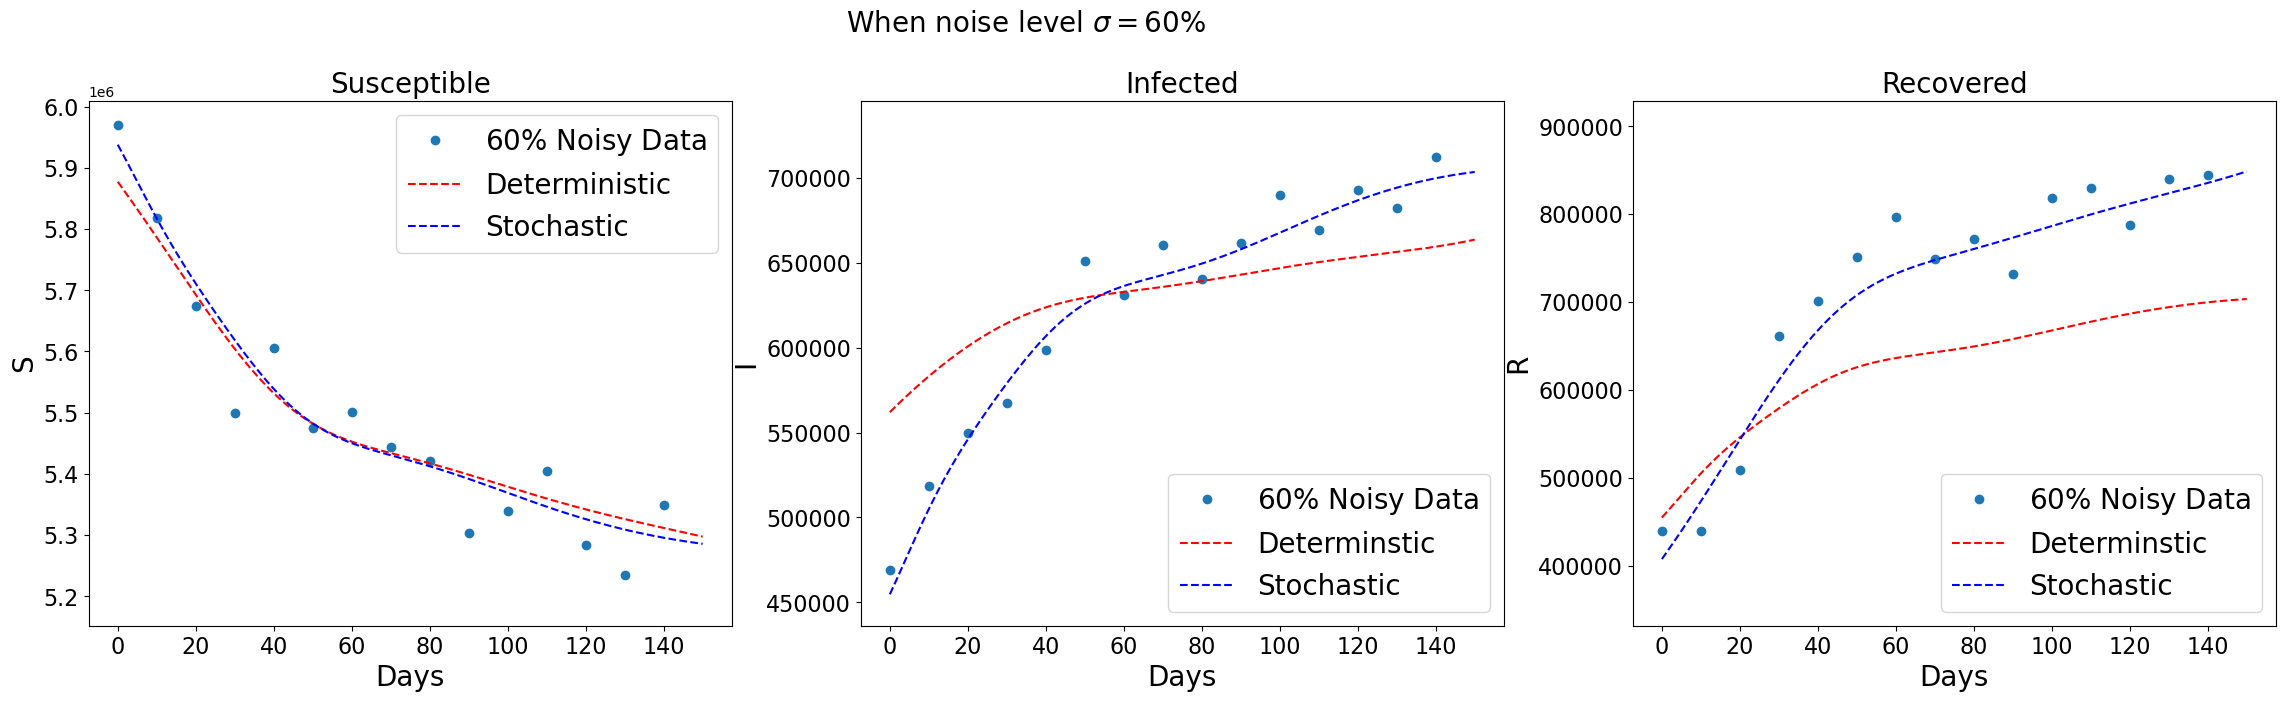

In [10]:
s10_s =np.loadtxt('Output/S_stoM_0.6_0.94_0.1.txt')*N
i10_s =np.loadtxt('Output/I_stoM_0.6_0.94_0.1.txt')*N
r10_s =np.loadtxt('Output/R_stoM_0.6_0.94_0.1.txt')*N
s10_std =np.loadtxt('Output/S_stoS_0.6_0.94_0.1.txt')*N
i10_std =np.loadtxt('Output/I_stoS_0.6_0.94_0.1.txt')*N
r10_std =np.loadtxt('Output/R_stoS_0.6_0.94_0.1.txt')*N
s10_d =np.loadtxt('Output1/S_det_0.6_0.94_0.1.txt')*N
i10_d =np.loadtxt('Output1/I_det_0.6_0.94_0.1.txt')*N
r10_d =np.loadtxt('Output1/R_det_0.6_0.94_0.1.txt')*N
n =1
Sd, Id, Rd =s10_d, i10_d, r10_s
Ss, Is, Rs =s10_s, i10_s, r10_d
S_std, I_std, R_std =s10_std, i10_std, r10_std
eta, v, sigma =0.94, 0.1, 0.60
S1, I1, R1 =S2c, I2c, R2c
name =r'$60\%$'

plotting_graphs(S1*N,I1*N, R1*N, n, Sd, Id, Rd, Ss, Is, Rs, eta, v, sigma, name, S_std, I_std, R_std)

## RMSE vs MAPE

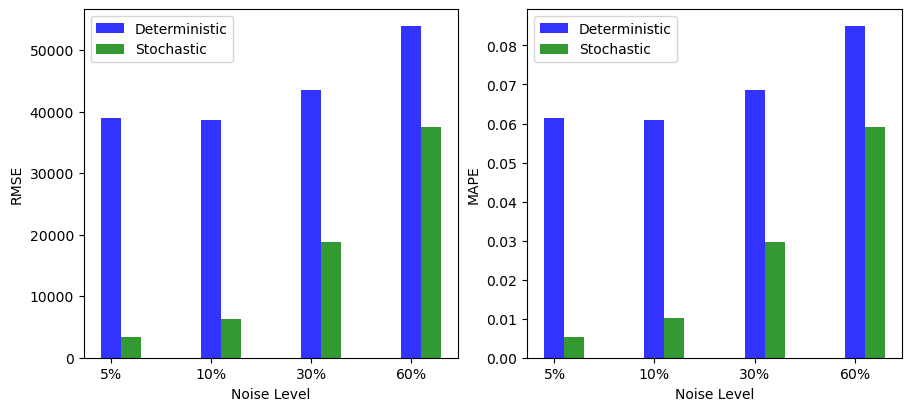

In [11]:
# noise = [r'$5\%$', r'$10\%$', r'$30\%$', r'$60\%$']
# # Set bar width
# bar_width = 0.2
# # Create the figure and axes objects
# fig6, ax1 = plt.subplots(constrained_layout=True,figsize=(5, 4))
# # Set the x-axis tick locations and labels
# ax1.set_xticks(np.arange(len(noise)))
# ax1.set_xticklabels(noise)
# # Set the y-axis label
# ax1.set_ylabel('CPU Time (Minutes)')
# ax1.set_xlabel('noise')
# # Set the chart title
# # ax1.set_title('Comparison of RMSE values for different layers and neurons')
# # Set the opacity of the bars
# opacity = 0.8
# # Plot the paired RMSE values
# rects1 = ax1.bar(np.arange(len(noise )), [45, 43, 42], bar_width, alpha=opacity, color='b', label='Deterministic')
# rects2 = ax1.bar(np.arange(len(noise )) + bar_width, [43, 42, 41], bar_width, alpha=opacity, color='g', label='Stochastic')
# ax1.legend()
# fig6.savefig(out+'rmse_vm.pdf')
# # fig6.savefig(out+'cputimeComp.eps')
# plt.show()


noise = [r'$5\%$', r'$10\%$', r'$30\%$', r'$60\%$']
# Set bar width
bar_width = 0.2
# Create the figure and axes objects
fig7, ax1 = plt.subplots(1, 2,constrained_layout=True,figsize=(9, 4))
# Set the x-axis tick locations and labels
ax1[0].set_xticks(np.arange(len(noise)))
ax1[0].set_xticklabels(noise)
# Set the y-axis label
ax1[0].set_ylabel('RMSE')
ax1[0].set_xlabel('Noise Level')
# Set the chart title
# ax1.set_title('Comparison of RMSE values for different layers and neurons')
# Set the opacity of the bars
opacity = 0.8
# Plot the paired RMSE values
rects1 = ax1[0].bar(np.arange(len(noise)), [39006, 38669, 43497, 53960], bar_width, alpha=opacity, color='b', label='Deterministic')
rects2 = ax1[0].bar(np.arange(len(noise)) + bar_width, [3363, 6371, 18802, 37557], bar_width, alpha=opacity, color='g', label='Stochastic')
ax1[0].legend()

# Set the x-axis tick locations and labels
ax1[1].set_xticks(np.arange(len(noise)))
ax1[1].set_xticklabels(noise)
# Set the y-axis label
ax1[1].set_ylabel('MAPE')
ax1[1].set_xlabel('Noise Level')
# Set the chart title
# ax1.set_title('Comparison of RMSE values for different layers and neurons')
# Set the opacity of the bars
opacity = 0.8
# Plot the paired RMSE values
rects1 = ax1[1].bar(np.arange(len(noise)), [0.0615, 0.0610, 0.0686, 0.0850], bar_width, alpha=opacity, color='b', label='Deterministic')
rects2 = ax1[1].bar(np.arange(len(noise)) + bar_width, [0.0053, 0.0101, 0.0297, 0.0592], bar_width, alpha=opacity, color='g', label='Stochastic')
ax1[1].legend()
# fig7.savefig(out+'rmse_mape.eps')
fig7.savefig(out+'rmse_mape.pdf')
plt.show()




## Nonlinear Incidence Rate

In [12]:
def nonlinear_incidence(gsi_a, gsi_p, I_a, I_p, name, v, sigma):
    fig2AB, ax1 = plt.subplots(1, 2,constrained_layout=True,figsize=(9, 4))
    days =np.arange(150)
    ax1[0].plot(days,  gsi_a, '.b')
    ax1[0].plot(days, gsi_p, '--r')
    ax1[0].set_xlabel('Days')
    ax1[0].set_ylabel(r'$g(S,I)$')
    ax1[0].legend([r'True $g(S,I)$',r'SEINN $g(S,I)$'])
    
    ax1[1].plot(days, I_a, '.b')
    ax1[1].plot(days, I_p, '--r')
    ax1[1].set_xlabel('Days')
    ax1[1].set_ylabel('Infected')
    ax1[1].legend(['{} Noise I'.format(name),'SEINN I' ])
    fig2AB.savefig(out+"nonlinear_{}_{}.pdf".format(v, sigma))
    plt.show()

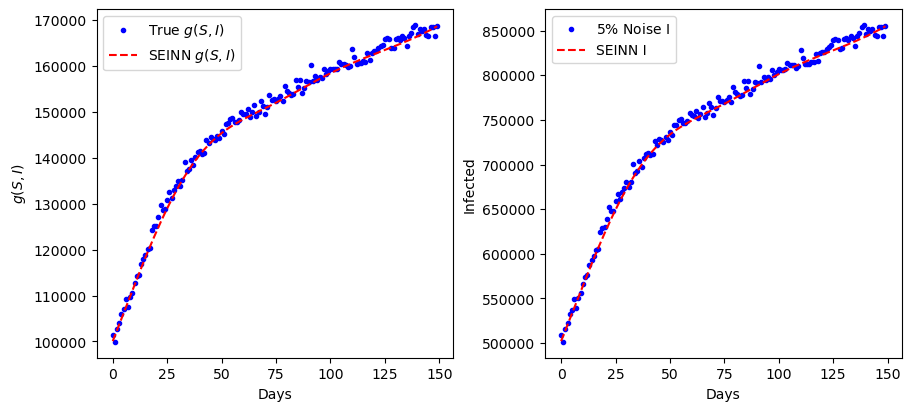

In [13]:
gsi51_a =np.loadtxt('Output_GSI/gsi_act_0.94_0.05_0.01.txt')
gsi51_p =np.loadtxt('Output_GSI/gsi_pred_0.94_0.05_0.01.txt')
I51_a =np.loadtxt('Output_GSI/I_true_0.94_0.05_0.01.txt')
I51_p =np.loadtxt('Output_GSI/I_pred_0.94_0.05_0.01.txt')
nonlinear_incidence(gsi51_a, gsi51_p, I51_a, I51_p, r'$5\%$',0.01,0.05)

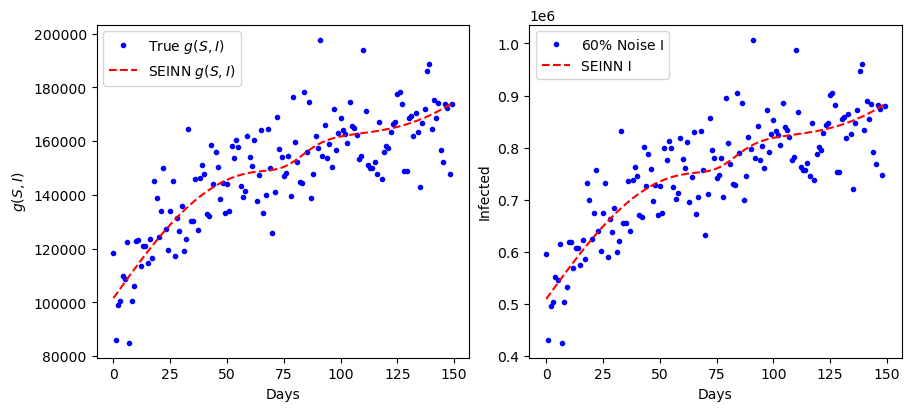

In [14]:
gsi51_a =np.loadtxt('Output_GSI/gsi_act_0.94_0.6_0.1.txt')
gsi51_p =np.loadtxt('Output_GSI/gsi_pred_0.94_0.6_0.1.txt')
I51_a =np.loadtxt('Output_GSI/I_true_0.94_0.6_0.1.txt')
I51_p =np.loadtxt('Output_GSI/I_pred_0.94_0.6_0.1.txt')
nonlinear_incidence(gsi51_a, gsi51_p, I51_a, I51_p, r'$60\%$',0.1,0.6)

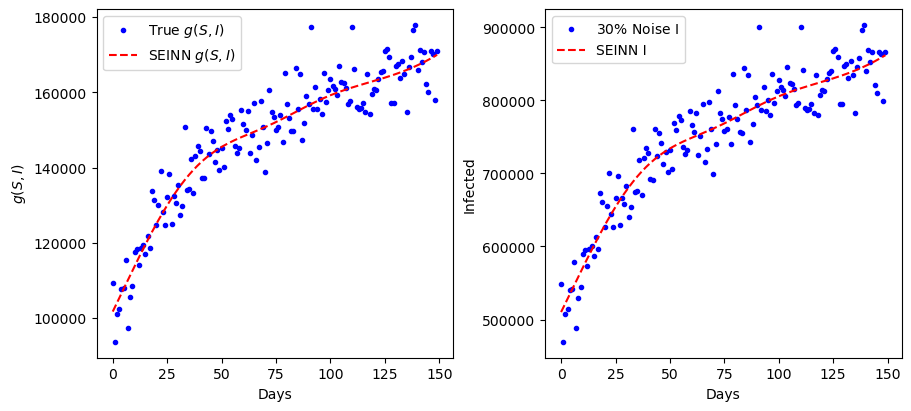

In [15]:
gsi51_a =np.loadtxt('Output_GSI/gsi_act_0.94_0.3_0.01.txt')
gsi51_p =np.loadtxt('Output_GSI/gsi_pred_0.94_0.3_0.01.txt')
I51_a =np.loadtxt('Output_GSI/I_true_0.94_0.3_0.01.txt')
I51_p =np.loadtxt('Output_GSI/I_pred_0.94_0.3_0.01.txt')
nonlinear_incidence(gsi51_a, gsi51_p, I51_a, I51_p, r'$30\%$',0.01,0.3)